In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [3]:
df = web.DataReader('ICICIBANK.NS', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,127.181816,124.563637,125.481819,126.645454,14927627.0,110.398727
2012-01-03,132.545456,128.181824,128.181824,131.963638,18500311.0,115.034676
2012-01-04,136.181824,132.800003,133.345459,135.109085,32952243.0,117.776611
2012-01-05,137.600006,134.363632,135.454544,136.018188,23203350.0,118.569077
2012-01-06,138.727264,132.363632,134.909088,136.672729,22273933.0,119.139679
...,...,...,...,...,...,...
2022-02-28,744.750000,715.400024,722.950012,742.700012,20547432.0,742.700012
2022-03-02,724.950012,707.750000,717.000000,714.849976,25252492.0,714.849976
2022-03-03,721.950012,693.450012,717.599976,698.299988,23190595.0,698.299988


In [73]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.81)
training_data_len

2033

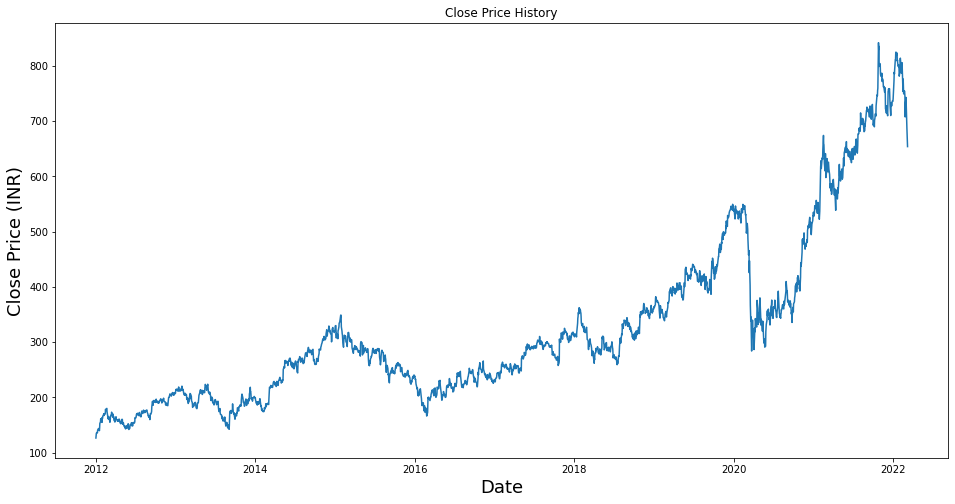

In [74]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [75]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.        ],
       [0.00743745],
       [0.01183634],
       ...,
       [0.79945583],
       [0.78512126],
       [0.73715291]])

In [76]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.        , 0.00743745, 0.01183634, 0.01310772, 0.01402309,
       0.01303143, 0.01982048, 0.02125713, 0.02157495, 0.02362184,
       0.02416854, 0.02263018, 0.01858725, 0.02559245, 0.03709825,
       0.04073433, 0.04869305, 0.04665887, 0.04866761, 0.03957739,
       0.05227827, 0.04916345, 0.05232912, 0.05587623, 0.05886391,
       0.06133035, 0.05693144, 0.0618516 , 0.05947417, 0.0605421 ,
       0.06284327, 0.07236575, 0.06922548, 0.07248017, 0.07494659,
       0.06640307, 0.06290684, 0.0597793 , 0.04854047, 0.05447773,
       0.0533335 , 0.04753611, 0.05241812, 0.04419243, 0.03984439,
       0.04159887, 0.05534225, 0.05909275, 0.05932159, 0.06543683,
       0.0594106 , 0.05623219, 0.05374033, 0.05391832, 0.06038954,
       0.05164259, 0.05441416, 0.04473912, 0.04611218, 0.04139544])]
[0.040480068468538105]



In [77]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [78]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1973, 60, 1)

In [79]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [80]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [81]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1973/1973 [==============================] - 34s 16ms/step - loss: 6.8747e-04


In [82]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [83]:
x_test = np.array(x_test)

In [84]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [85]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [86]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7.070150679900866

C:\Users\kapoo\AppData\Local\Temp/ipykernel_11024/3428246292.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


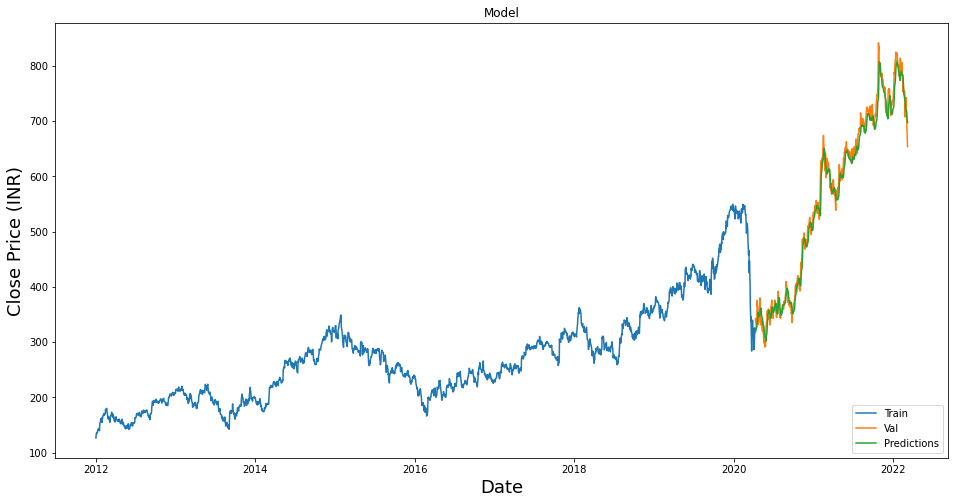

In [87]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [88]:
valid

,Close,Predictions
Date,,
2020-04-09,342.700012,317.807220
2020-04-13,330.649994,323.352875
2020-04-15,327.350006,327.988739
2020-04-16,342.000000,330.752747
2020-04-17,375.549988,334.725494
...,...,...
2022-02-28,742.700012,718.837463
2022-03-02,714.849976,718.544739
2022-03-03,698.299988,714.849121


In [89]:
icici_quote = web.DataReader('ICICIBANK.NS', data_source='yahoo',start='2012-01-01', end='2022-03-08')
new_df = icici_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[681.0909]]


In [91]:
icici_quote2 = web.DataReader('ICICIBANK.NS', data_source='yahoo',start='2022-03-01', end='2022-03-08')
print(icici_quote2['Close'])

Date
2022-03-02    714.849976
2022-03-03    698.299988
2022-03-04    688.049988
2022-03-07    653.750000
Name: Close, dtype: float64
